In [1]:
import json
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')

import numpy       as np
import hipy.pltext as pltext
import awkward     as ak
import matplotlib.pyplot as plt

from wcte.brbtools import sort_run_files, get_part_files, select_good_parts, create_df_from_file
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

pltext.style()

In [2]:
def get_files_from_part(part_file, run_files):
    """
    Input a part_file number and the run_files list created with sort_run_files.
    Extracts all the card_id, channel_id, charge and time information from the hits.
    Returns the arrays for the variables for the part_file.
    """
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()
    file_event_number    = tree["event_number"].array()

    return file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times, file_event_number

In [3]:
run        = 1626
run_files  = sort_run_files(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
part_files = get_part_files(run_files)
good_parts = select_good_parts(part_files, run_files)

Selecting Good Parts: 100%|██████████| 9/9 [00:00<00:00, 34.44it/s]


In [4]:
with open('/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger/mmc_map_R1609.json') as f:
    mcc_map = json.load(f)

d = {}
for k,v in zip(mcc_map.keys(), mcc_map.values()):
    card, channel = [int(i) for i in str(int(k)/100).split(".")]
    d[(card, channel)] = v

mcc_map = d

In [ ]:
max_card = 118
max_chan = 19
evt_offset = 0

builder_evt    = []
builder_time   = []
builder_card   = []
builder_chan   = []
builder_charge = []

for part in tqdm(good_parts[:2], total=len(good_parts[:2])):
    # Read DataFrame
    df_part = create_df_from_file(get_files_from_part(good_parts[part], run_files))

    # Variables
    events = df_part.evt.values + evt_offset
    cards  = df_part.card.values
    chans  = df_part.channel.values
    charges = df_part.charge.values

    # Correct times with event much faster with pd.Series than with the flattened arrays
    corrected_times = np.array([
        time + (event // 512) * (2**35) + ((event % 512 == 511) & (time < 2**34)) * (2**35)
        for time, event in tqdm(zip(df_part.time, df_part.evt + evt_offset), total=len(df_part.time), leave=False)
    ])

    # Correct times with mcc_constants
    lookup = np.zeros((max_card + 1, max_chan + 1))
    for (card, chan), shift in mcc_map.items():
        lookup[card, chan] = shift
    corrections = lookup[df_part.card, df_part.channel]

    corrected_times = corrected_times + corrections

    # Append part_file info
    builder_evt   .append(events)
    builder_time  .append(corrected_times)
    builder_card  .append(cards)
    builder_chan  .append(chans)
    builder_charge.append(charges)

    evt_offset = df_part.evt.max() + 1

print("Outputing...")
run_events  = ak.concatenate(builder_evt   )
run_times   = ak.concatenate(builder_time  )
run_cards   = ak.concatenate(builder_card  )
run_chans   = ak.concatenate(builder_chan  )
run_charges = ak.concatenate(builder_charge)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26914538 [00:00<?, ?it/s]

  0%|          | 0/43149124 [00:00<?, ?it/s]

Outputing...


In [8]:
subset_t = run_times[::10000]
subset_e = run_events[::10000]

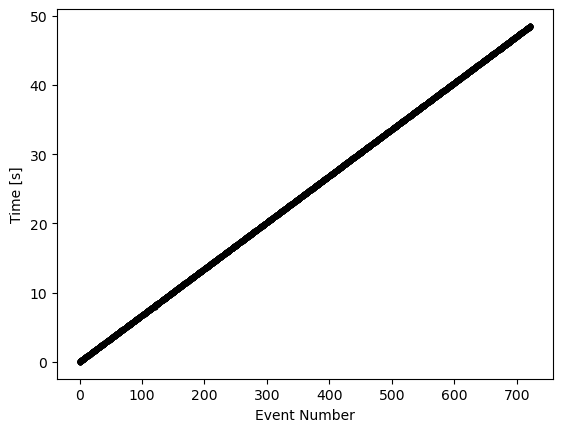

In [10]:
plt.scatter(subset_e, subset_t/1e9, marker=".");
plt.ylabel("Time [s]");
plt.xlabel("Event Number");

In [19]:
cards = np.unique(run_cards)

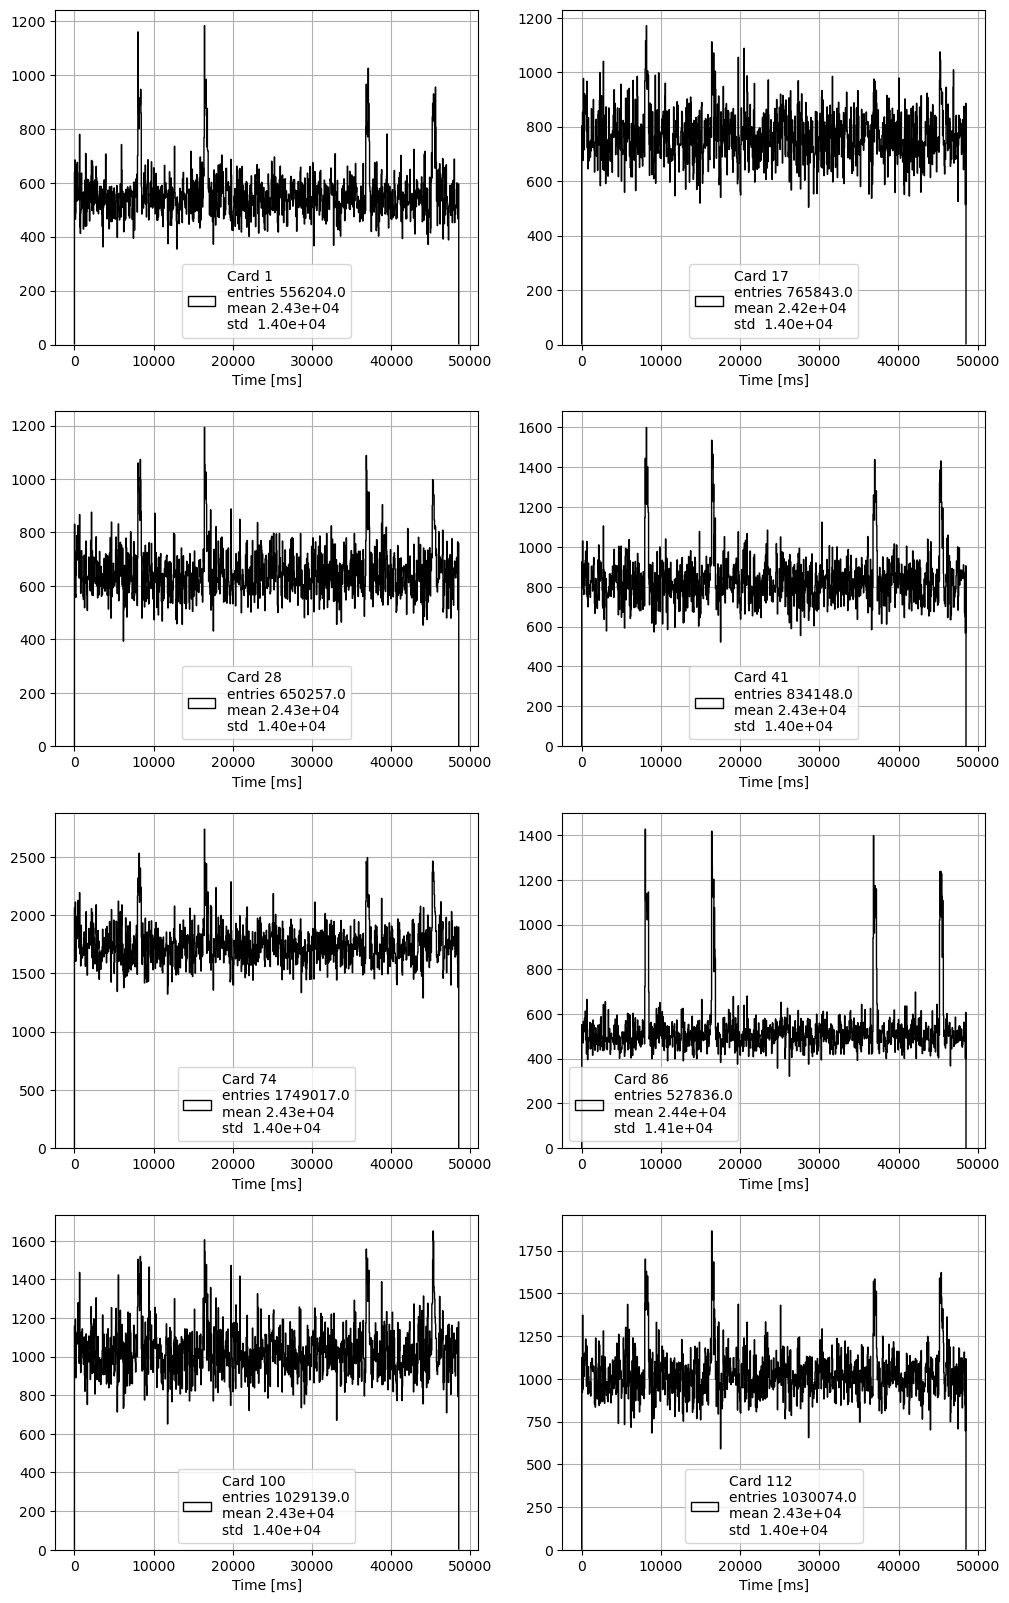

In [20]:
subplot = pltext.canvas(8)

for i, card in enumerate(cards[::11]):
    mask = (run_cards == card)
    card_hit_times = run_times[mask]

    subplot(i+1)
    pltext.hist(card_hit_times/1e6, 1000, xylabels=("Time [ms]"), formate=".2e", label=f"Card {card}");